In [1]:
## CAMERA CALIBRATION

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite('camera_cal/Corners_found/'+write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

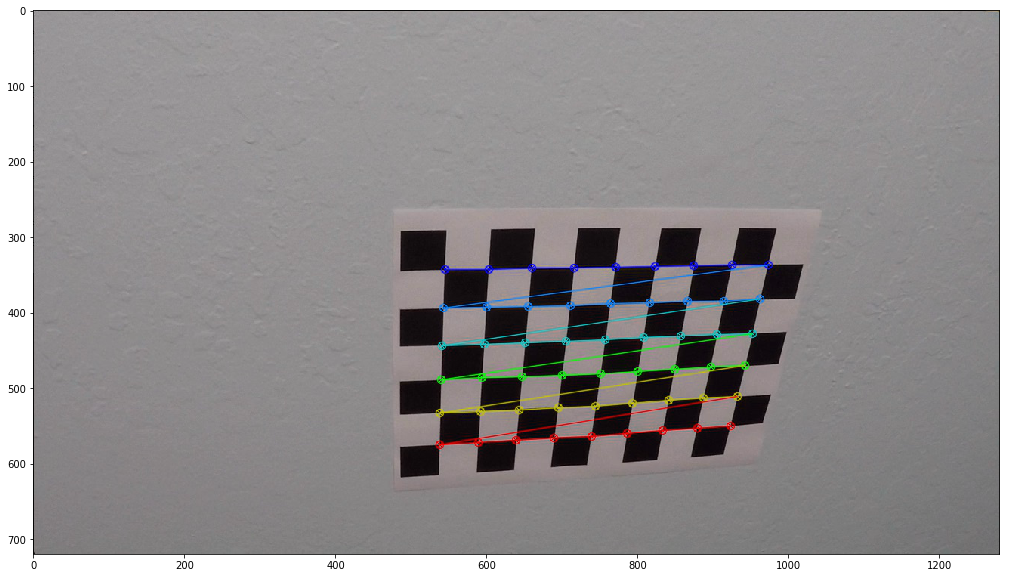

In [2]:
img = cv2.imread('camera_cal/Corners_found/corners_found1.jpg')
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(img)

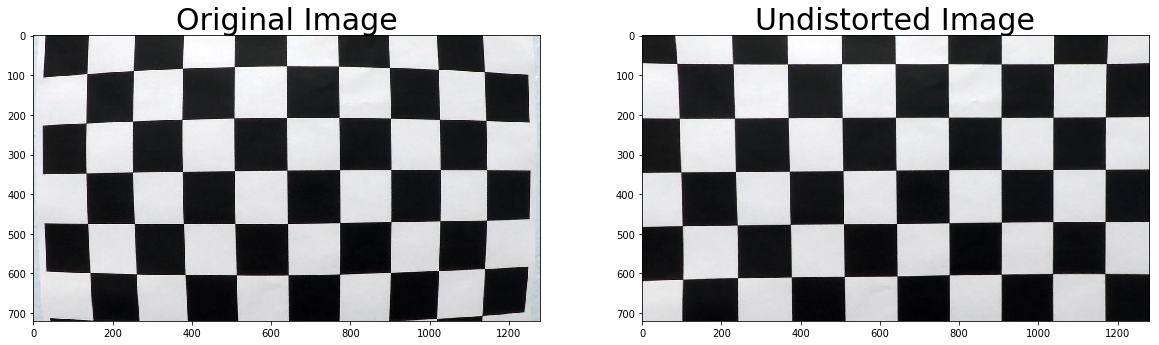

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/distored_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Start Pipeline
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

In [6]:
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    #undist = cv2.undistort(img, mtx, dist, None, mtx)        
    h,w =img.shape[:2]
            
    src = np.float32([[w,h-10], #rd
                     [540,470], #lu
                     [740,470], #ru
                     [0, h-10]]) #ld
    dst= np.float32([[w,h], #rd
                     [0,0], #lu
                     [w,0], #ru
                     [0, h]]) #ld
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


In [13]:
 # undistort image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
__img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort(__img, mtx, dist)
cv2.imwrite('output_images/undistorted.jpg', undist)

binary_img = binary(undist, s_thresh=(170, 255), sx_thresh=(20, 100))
cv2.imwrite('output_images/binary_image.jpg', undist)

unwarp, M, Mi = corners_unwarp(binary_img, mtx, dist)
cv2.imwrite('output_images/unwarp.jpg', unwarp)

True

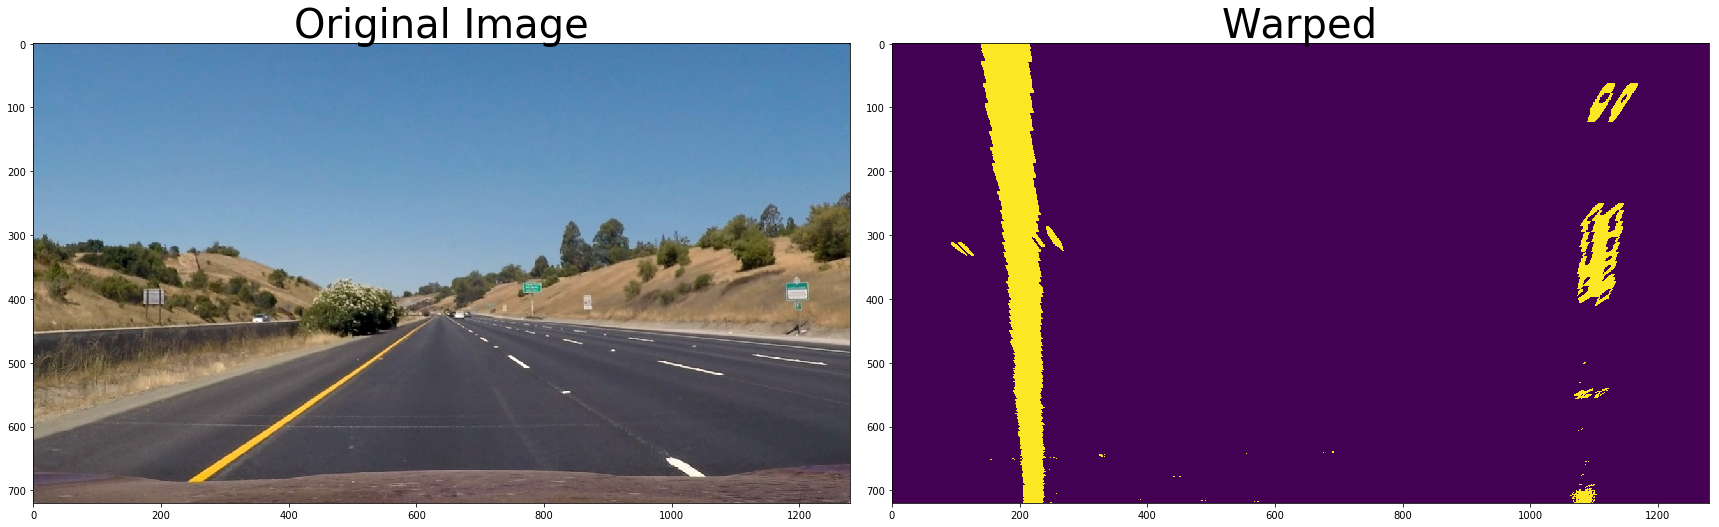

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipeline_img(img, mtx, dist):
    
    # undistort image
    undist = undistort(img, mtx, dist)
    
    # create binary
    binary_img = binary(undist, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    # birdeye
    img_unwarped, M, Minv = corners_unwarp(binary_img, mtx, dist)
    
    return img_unwarped, M, Minv

__img = mpimg.imread('test_images/straight_lines1.jpg')
binary_warped, M, Minv= pipeline_img(__img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(__img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped)
ax2.set_title('Warped', fontsize=40)


D:\Programme (x86)\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


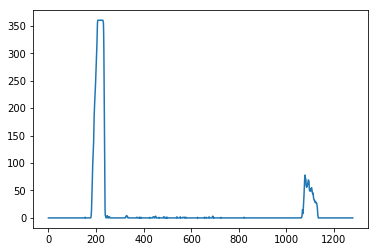

In [62]:


import numpy as np


histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)


In [63]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

In [64]:
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit)

[ -5.03641245e-05   1.00443005e-01   1.75087536e+02]


(720, 0)

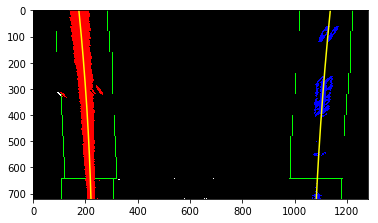

In [65]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

True

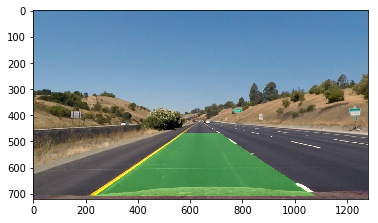

In [66]:
undist = undistort(__img, mtx, dist)
warped = binary_warped
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (__img.shape[1], __img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
cv2.imwrite('output_images/final_straight_lines1.jpg',result)